In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import time
import matplotlib.pyplot as plt
from collections import Counter
from subprocess import check_output

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFECV

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

## Dataset loading

In [2]:
def get_data(data_type, device, name, extension, sep):
    """
    data_type: type of data to return: Normal, Mirai, RouterSploit, UFONet
    device: the device name: archer, camera, indoor, philips, wr940n
    name: network or energy
    extension: file format
    sep: file delimiter
    """
    path = './QRS_dataset'
    types = {'mirai':'Mirai', 'normal':'Normal', 'rs':'RouterSploit', 'ufo':'UFONet'}

    if data_type in types.keys():
        data_type = types[data_type]
    
    if data_type not in os.listdir(path):
        print('Bad data type')
        return False
    
    path += f'/{data_type}'
    if data_type == 'Normal': 
        path += '/Normal'
    
    path += f'/{name}/{device}'
    
    if data_type == 'Normal': 
        path += '-normal1'
    else:
        path += '-attack1'

    path += extension

    return pd.read_csv(path, sep=sep, on_bad_lines='skip')

def get_data_network(data_type, device):
    data = get_data(data_type, device, 'network', '.csv', ';')
    data.drop(['Info', 'No.'], axis=1, inplace=True)
    
    return data

def get_data_energy(data_type, device):
    data = get_data(data_type, device, 'energy', '.amp', ',')
    data['time'] /= 1000    # converting millis seconds
    data.drop('timestamp', axis=1, inplace=True)

    # rounding time to the nearest second
    data['time'] = data['time'].apply(round)
    data.drop_duplicates('time', inplace=True)
    data.reset_index(inplace=True, drop=True)

    return data

def get_data_and_preprocess(data_type, device):
    """
    data_type: type of data to return: Normal, Mirai, RouterSploit, UFONet
    device: the device name: archer, camera, indoor, philips, wr940n
    """
    data_network = get_data_network(data_type, device)
    data_energy = get_data_energy(data_type, device)

    # adding the energy usage for every packet
    data_network['Energy_Time'] = data_network['Time'].apply(round)
    data_network.drop(inplace=True, index=np.where(data_network['Energy_Time']>=data_energy['time'].max())[0])
    data_network['energy'] = list(data_energy.loc[list(data_network['Energy_Time']), 'energy'])
    data_network.drop('Energy_Time', axis=1, inplace=True)

    data_network['target'] = data_type

    data_network.reset_index(inplace=True, drop=True)

    return data_network, data_energy


In [12]:
normal_network, normal_energy = get_data_and_preprocess('normal', 'archer')
mirai_network, mirai_energy = get_data_and_preprocess('mirai', 'archer')

In [4]:
normal_network

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
670,1783.318520,8.8.8.8,172.31.1.15,DNS,94,0.22,normal
671,1785.845176,172.31.1.15,8.8.8.8,DNS,68,0.22,normal
672,1785.858714,8.8.8.8,172.31.1.15,DNS,100,0.22,normal
673,1790.909397,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.21,normal


In [5]:
normal_energy

,energy,time
0,0.00,0
1,0.00,1
2,0.06,2
3,0.11,3
4,0.12,4
...,...,...
1792,0.22,1792
1793,0.22,1793
1794,0.22,1794
1795,0.23,1795


In [16]:
# Get both network datasets in the same time-frame
max_time = min(normal_network['Time'].max(), normal_network['Time'].max())

normal_network.drop(inplace=True, index=np.where(normal_network['Time']>max_time)[0])
normal_energy.drop(inplace=True, index=np.where(normal_energy['time']>max_time)[0])
mirai_network.drop(inplace=True, index=list(np.where(mirai_network['Time']>max_time)[0]))
mirai_energy.drop(inplace=True, index=list(np.where(mirai_energy['time']>max_time)[0]))

normal_network.reset_index(inplace=True, drop=True)
normal_energy.reset_index(inplace=True, drop=True)
mirai_network.reset_index(inplace=True, drop=True)
mirai_energy.reset_index(inplace=True, drop=True)

In [17]:
print(normal_network.shape)
print(mirai_network.shape)
print(normal_energy.shape)
print(mirai_energy.shape)

(675, 7)
(438906, 7)
(1791, 2)
(1791, 2)


## Energy usage

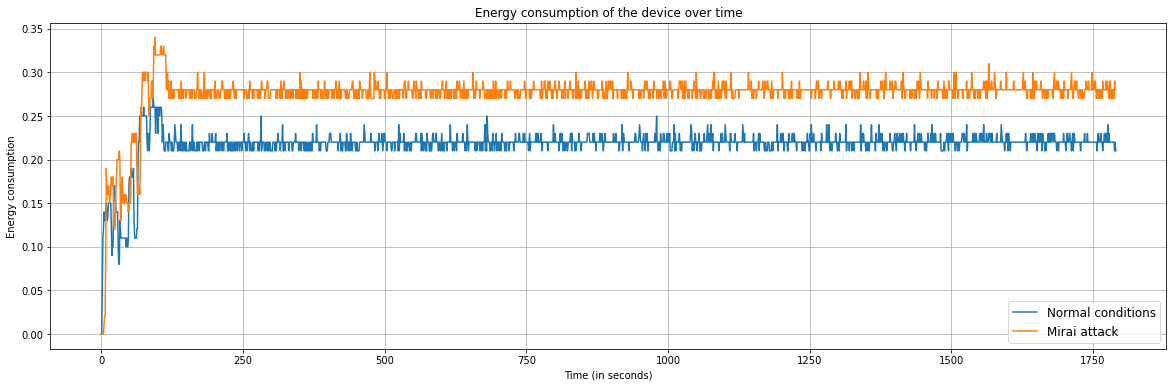

In [116]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

ax.plot(normal_energy['time'], normal_energy['energy'], label='Normal conditions')
ax.plot(mirai_energy['time'], mirai_energy['energy'], label='Mirai attack')
ax.set_title('Energy consumption of the device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

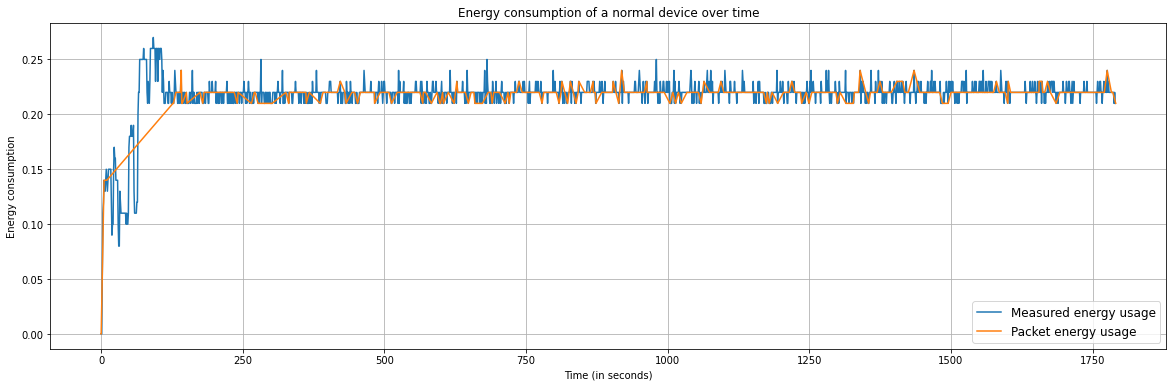

In [117]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

max_time = min(normal_energy['time'].max(), mirai_energy['time'].max())

ax.plot(normal_energy['time'], normal_energy['energy'], label='Measured energy usage')
ax.plot(normal_network['Time'], normal_network['energy'], label='Packet energy usage')
ax.set_title('Energy consumption of a normal device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

## Protocol study

In [118]:
# normal_network = normal_network[normal_network.Protocol != 'ICMP']
# mirai_network = mirai_network[mirai_network.Protocol != 'ICMP']

print("Protocols:", normal_network['Protocol'].unique())

Protocols: ['DNS' 'ARP' 'DHCP' 'ICMP' 'TCP' 'TLSv1.2' 'NTP']


In [119]:
print("Count of the packets of each protocol")
df = pd.DataFrame()
df['Normal'] = normal_network.groupby('Protocol').count()['Length']
df['Mirai attack'] = mirai_network.groupby('Protocol').count()['Length']
df

Count of the packets of each protocol


,Normal,Mirai attack
Protocol,,
ARP,178,200
DHCP,12,12
DNS,430,464
ICMP,1,244
NTP,4,4
TCP,32,437950
TLSv1.2,18,30


<AxesSubplot:title={'center':'Bar graph for each protocol in normal communications'}, ylabel='Count'>

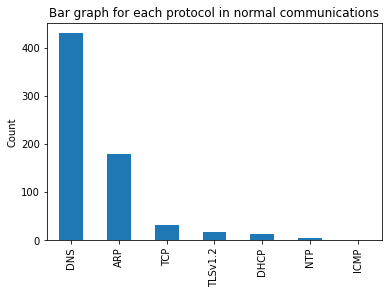

In [120]:
normal_network['Protocol'].value_counts().plot.bar(title="Bar graph for each protocol in normal communications", ylabel="Count")

In [121]:
# normal_network['TCP_Protocol'] = np.where(normal_network['Protocol'] == 'TCP', 1, 0)
# mirai_network['TCP_Protocol'] = np.where(mirai_network['Protocol'] == 'TCP', 1, 0)

## Getting data ready for the model

In [122]:
normal_network.corr()

,Time,Length,energy
Time,1.000000,-0.105717,0.104204
Length,-0.105717,1.000000,0.052379
energy,0.104204,0.052379,1.000000


In [123]:
Final_merge = normal_network.append(mirai_network)
Final_merge

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
438901,1786.267402,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438902,1786.267408,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438903,1786.267413,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438904,1786.267417,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai


In [124]:
Final_merge.groupby('Protocol').count()

,Time,Source,Destination,Length,energy,target
Protocol,,,,,,
ARP,378,378,378,378,378,378
DHCP,24,24,24,24,24,24
DNS,894,894,894,894,894,894
ICMP,245,245,245,245,245,245
ICMPv6,2,2,2,2,2,2
NTP,8,8,8,8,8,8
TCP,437982,437982,437982,437982,437982,437982
TLSv1.2,48,48,48,48,48,48


In [125]:
Final_merge = Final_merge[Final_merge.Protocol != 0]

In [126]:
# protocol_type feature mapping
dic_protocoles = {'DNS':0, 'ARP':1, 'DHCP':2, 'ICMP':3, 'TCP':4, 'TLSv1.2':5, 'NTP':6, 'ICMPv6':7}
Final_merge['Protocol'] = Final_merge['Protocol'].map(dic_protocoles)

In [127]:
le = preprocessing.LabelEncoder()
Final_merge['Source'] = le.fit_transform(Final_merge.Source.values)
Final_merge['Destination'] = le.fit_transform(Final_merge.Destination.values)

In [128]:
dic_attacks = {'normal':0, 'mirai':1}
Final_merge['target'] = Final_merge['target'].map(dic_attacks)

In [129]:
Final_merge

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,7,12,0,71,0.00,0
1,0.020682,12,6,0,135,0.00,0
2,5.002782,14,14,1,60,0.14,0
3,5.002810,13,15,1,42,0.14,0
4,5.053399,13,15,1,42,0.14,0
...,...,...,...,...,...,...,...
438901,1786.267402,5,6,4,74,0.28,1
438902,1786.267408,5,6,4,74,0.28,1
438903,1786.267413,5,6,4,74,0.28,1
438904,1786.267417,5,6,4,74,0.28,1


In [130]:
Final_merge.to_csv('QRS_dataset/FinalSet.csv')

## Random Forest

In [131]:
def entropy(y):
    hist = np.bincount(y['target'])
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [132]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [133]:
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(X.iloc[i], self.root) for i in range(X.shape[0])])
        #return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X.iloc[:, best_feat], best_thresh)
        left = self._grow_tree(X.iloc[left_idxs, :], y.iloc[left_idxs], depth+1)
        right = self._grow_tree(X.iloc[right_idxs, :], y.iloc[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X.iloc[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y.iloc[left_idxs]), entropy(y.iloc[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column.values <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column.values > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [134]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X.iloc[idxs], y.iloc[idxs]

In [135]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [136]:
class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

## Random Forest evaluation

In [137]:
# Target variable and train set
y = Final_merge[['target']]
X = Final_merge.drop(['target', ], axis = 1)

# Split test and train data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 42)
print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 175832
Test size:  263749


In [138]:
use_hand_made_random_forest = False

if use_hand_made_random_forest:
    clf = RandomForest(n_trees = 5)
else:
    clf = RandomForestClassifier(5)

clf.fit(X_train, y_train['target'])

RandomForestClassifier(n_estimators=5)

In [139]:
print("Original mirai packet share:", mirai_network.shape[0]/(normal_network.shape[0]+mirai_network.shape[0]))

print("Score:", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

dic_attacks_inv = {v:k for v,k in enumerate(dic_attacks)}

unique, counts = np.unique(y_pred, return_counts=True)
unique = [dic_attacks_inv[u] for u in unique]
df = pd.DataFrame(index=unique)
df['predicted'] = counts
unique, counts = np.unique(y_test, return_counts=True)
df['actual'] = counts
df

Original mirai packet share: 0.9984644468254997
Score: 0.9999696681314432


,predicted,actual
normal,404,402
mirai,263345,263347


In [140]:
clf_cv_score = cross_val_score(clf, X, y['target'], cv=10, scoring='roc_auc')
clf_cv_score

array([0.99864437, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [141]:
print("=================== Confusion Matrix ======================")
print(metrics.confusion_matrix(y_test, y_pred))
print('\n') 
print("=================== Classification Report =================")
print(metrics.classification_report(y_test, y_pred))
print('\n') 
print("=================== All AUC Scores =======================")
print(clf_cv_score)
print('\n') 
print("=================== Mean AUC Score =======================")
print("Mean AUC Score - Random Forest: ", clf_cv_score.mean())

=================== Confusion Matrix ======================
[[   399      3]
 [     5 263342]]


=================== Classification Report =================
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       402
           1       1.00      1.00      1.00    263347

    accuracy                           1.00    263749
   macro avg       0.99      1.00      1.00    263749
weighted avg       1.00      1.00      1.00    263749



=================== All AUC Scores =======================
[0.99864437 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


=================== Mean AUC Score =======================
Mean AUC Score - Random Forest:  0.9998644369005035


In [142]:
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)

Score list: [8.37216346e+03 1.34653306e+03 6.83566397e+02 7.30046739e+02
 4.21591787e+03 3.50055064e+00]
Feature list: Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'energy'], dtype='object')


In [143]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier(5) 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train['target'])

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['Time', 'Destination', 'Protocol', 'Length', 'energy'], dtype='object')


In [144]:
rfecv.grid_scores_

/home/alexis/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


array([[0.99997156, 0.99997156, 1.        , 1.        , 0.99997156],
       [0.99994313, 0.99997156, 1.        , 1.        , 0.99997156],
       [0.99997156, 1.        , 0.99997156, 0.99997156, 1.        ],
       [0.99997156, 0.99994313, 1.        , 1.        , 0.99997156],
       [0.99997156, 1.        , 1.        , 1.        , 1.        ],
       [0.99997156, 0.99997156, 1.        , 1.        , 0.99997156]])

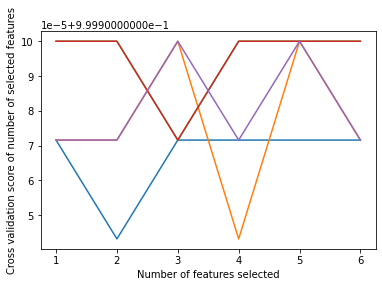

In [145]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

/tmp/ipykernel_3159/1353532891.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clr_rf_5 = clf_rf_5.fit(X_train,y_train)


Feature ranking:
1. feature 5 (0.658508)
2. feature 1 (0.161980)
3. feature 4 (0.101999)
4. feature 0 (0.046607)
5. feature 3 (0.018583)
6. feature 2 (0.012324)


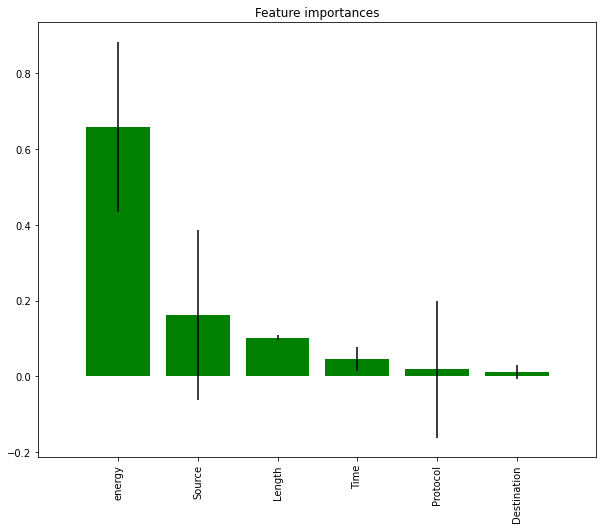

In [146]:
clf_rf_5 = RandomForestClassifier(5)
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
#plt.savefig('books_read.png')

## Federated

Check out the folder `flower test`